# AIS Data Exploration

Exploration of SPIRE automatic identification system (AIS) data from April and May 2017.

Data consists of a position table containing information about a vessels current location, course, etc, a second static table has meta-data about the vessel such as the vessel IMO, name, length, and width. 

**Static fields**: <br>
['msg_type', 'mmsi', 'timestamp', 'nmea', 'imo', 'name', 'ship_and_cargo_type', 'length', 'width', 'draught', 'eta_date', 'destination', 'call_sign']

**Position data fields**: <br>
['msg_type', 'mmsi', 'timestamp', 'nmea', 'status', 'rot', 'speed', 'accuracy', 'longitude', 'latitude', 'course', 'heading', 'manever', 'geom']

**virtual environment** "ais_data"

In [59]:
import pandas as pd
import bokeh
import datashader as ds

import datashader.transfer_functions as tf
from functools import partial
from datashader.utils import export_image
from datashader.colors import colormap_select, Greys9, Hot, viridis, inferno

import folium
from folium import plugins

from datetime import datetime, time
import matplotlib
import matplotlib.pyplot as plt

%pylab inline
pylab.rcParams['figure.figsize'] = (15, 5)
plt.rcParams['axes.facecolor']='white'

import warnings
warnings.filterwarnings('ignore')

import ais_query

import imp
imp.reload(ais_query)

Populating the interactive namespace from numpy and matplotlib


<module 'ais_query' from '/mnt/data/wgrimes/wef_oceans/ais_query.py'>

In [4]:
cols_position = ais_query.columns_position
cols_static = ais_query.columns_static

# Static AIS

## number of rows

In [4]:
sql_statement = """
SELECT COUNT(*)
FROM ais_messages.ais_static;
"""
number_of_rows = int(ais_query.connect(sql_statement).iloc[0])
print("number of rows = ", number_of_rows)

number of rows =  1031659


## nulls and unique table

In [7]:
sql_statement = """
SELECT
COUNT(msg_type) AS msg_type,
COUNT(mmsi) AS mmsi,
COUNT(timestamp) AS timestamp,
COUNT(nmea) AS nmea,
COUNT(imo) AS imo,
COUNT(name) AS name,
COUNT(ship_and_cargo_type) AS ship_and_cargo_type,
COUNT(length) AS length,
COUNT(width) AS width,
COUNT(draught) AS draught,
COUNT(eta_date) AS eta_date,
COUNT(destination) AS destination,
COUNT(call_sign) AS call_sign
FROM ais_messages.ais_static; 
"""
summary = ais_query.connect(sql_statement)
summary = summary.append(number_of_rows - summary.loc[0], ignore_index=True)
summary = summary.append((summary.loc[1]/number_of_rows)*100, ignore_index=True).astype(int)

sql_statement = """
SELECT
COUNT(DISTINCT msg_type) AS msg_type,
COUNT(DISTINCT mmsi) AS mmsi,
COUNT(DISTINCT timestamp) AS timestamp,
COUNT(DISTINCT nmea) AS nmea,
COUNT(DISTINCT imo) AS imo,
COUNT(DISTINCT name) AS name,
COUNT(DISTINCT ship_and_cargo_type) AS ship_and_cargo_type,
COUNT(DISTINCT length) AS length,
COUNT(DISTINCT width) AS width,
COUNT(DISTINCT draught) AS draught,
COUNT(DISTINCT eta_date) AS eta_date,
COUNT(DISTINCT destination) AS destination,
COUNT(DISTINCT call_sign) AS call_sign
FROM ais_messages.ais_static; 
"""
distinct = ais_query.connect(sql_statement)
summary = summary.append(distinct, ignore_index=True)

summary = summary.rename(index={0: 'not-null', 1: 'null', 2: 'percentage_null', 3: 'number of unique'})
summary.columns = cols_static

summary

msg_type     mmsi  timestamp     nmea     imo    name  \
not-null           1031659  1031659    1031659  1031659  603903  926872   
null                     0        0          0        0  427756  104787   
percentage_null          0        0          0        0      41      10   
number of unique         2    65615     819901  1031659   39265   60926   

                  ship_and_cargo_type  length   width  draught  eta_date  \
not-null                       708690  708539  708539   603903    524648   
null                           322969  323120  323120   427756    507011   
percentage_null                    31      31      31       41        49   
number of unique                  256    1016     127      256     18230   

                  destination  call_sign  
not-null               603903     708690  
null                   427756     322969  
percentage_null            41         31  
number of unique        38219      54390

# Position AIS

## number of rows

In [ ]:
sql_statement = """
SELECT COUNT(*)
FROM ais_messages.ais_position;
"""
number_of_rows = int(ais_query.connect(sql_statement).iloc[0])
print("number of rows = ", number_of_rows)

## nulls and unique table

In [56]:
sql_statement = """
SELECT
COUNT(msg_type) AS msg_type,
COUNT(mmsi) AS mmsi,
COUNT(timestamp) AS timestamp,
COUNT(nmea) AS nmea,
COUNT(status) AS status,
COUNT(rot) AS rot,
COUNT(speed) AS speed,
COUNT(accuracy) AS accuracy,
COUNT(longitude) AS longitude,
COUNT(latitude) AS latitude,
COUNT(course) AS course,
COUNT(heading) AS heading,
COUNT(manever) AS menever,
COUNT(geom) AS geom
FROM ais_messages.ais_position; 
"""
summary = ais_query.connect(sql_statement)
summary = summary.append(number_of_rows - summary.loc[0], ignore_index=True)
summary = summary.append((summary.loc[1]/number_of_rows)*100, ignore_index=True).astype(int)

sql_statement = """
SELECT
COUNT(DISTINCT msg_type) AS msg_type,
COUNT(DISTINCT mmsi) AS mmsi,
COUNT(DISTINCT timestamp) AS timestamp,
COUNT(DISTINCT nmea) AS nmea,
COUNT(DISTINCT status) AS status,
COUNT(DISTINCT rot) AS rot,
COUNT(DISTINCT speed) AS speed,
COUNT(DISTINCT accuracy) AS accuracy,
COUNT(DISTINCT longitude) AS longitude,
COUNT(DISTINCT latitude) AS latitude,
COUNT(DISTINCT course) AS course,
COUNT(DISTINCT heading) AS heading,
COUNT(DISTINCT manever) AS menever,
COUNT(DISTINCT geom) AS geom
FROM ais_messages.ais_position; 
"""
distinct = ais_query.connect(sql_statement)
summary = summary.append(distinct, ignore_index=True)

summary = summary.rename(index={0: 'not-null', 1: 'null', 2: 'percentage_null', 3: 'number of unique'})
summary.columns = cols_position
summary

msg_type      mmsi  timestamp      nmea    status       rot  \
not-null      23861636  23861636   23861636  23861636  23153740  22012064   
null                 0         0          0         0    707896   1849572   
percent_null         0         0          0         0         2         7   
unique               5    245807    3753364  23861636        16       123   

                 speed  accuracy  longitude  latitude    course   heading  \
not-null      23861636  23861636   23861636  23861636  23861636  22719960   
null                 0         0          0         0         0   1141676   
percent_null         0         0          0         0         0         4   
unique            1024         2   15573883  11940130      4198       512   

               manever      geom  
not-null      23153740  23861636  
null            707896         0  
percent_null         2         0  
unique               4  21299917

# MMSI intersection Position and Static

In [7]:
sql_statement = """
SELECT COUNT(*) FROM
(
SELECT DISTINCT(mmsi) FROM ais_messages.ais_static
INTERSECT
SELECT DISTINCT(mmsi) FROM ais_messages.ais_position
) I
"""
number_of_intersections = int(ais_query.connect(sql_statement).iloc[0])
print("intersection of unique MMSI = ", number_of_intersections)

intersection of unique MMSI =  44183


# Map Global AIS Positions 

In [5]:
sql_statement = """
SELECT mmsi, longitude, latitude, timestamp
FROM ais_messages.ais_position;
"""
ais_position_all = ais_query.connect(sql_statement)
ais_position_all.columns = ['mmsi','longitude', 'latitude', 'timestamp']

### AIS all vessels

/home/wgrimes/.conda/envs/ais_data/lib/python3.5/site-packages/datashader/transfer_functions.py:162: DeprecationWarning: `interpolate` is deprecated; use `shade` instead
  warnings.warn(w)


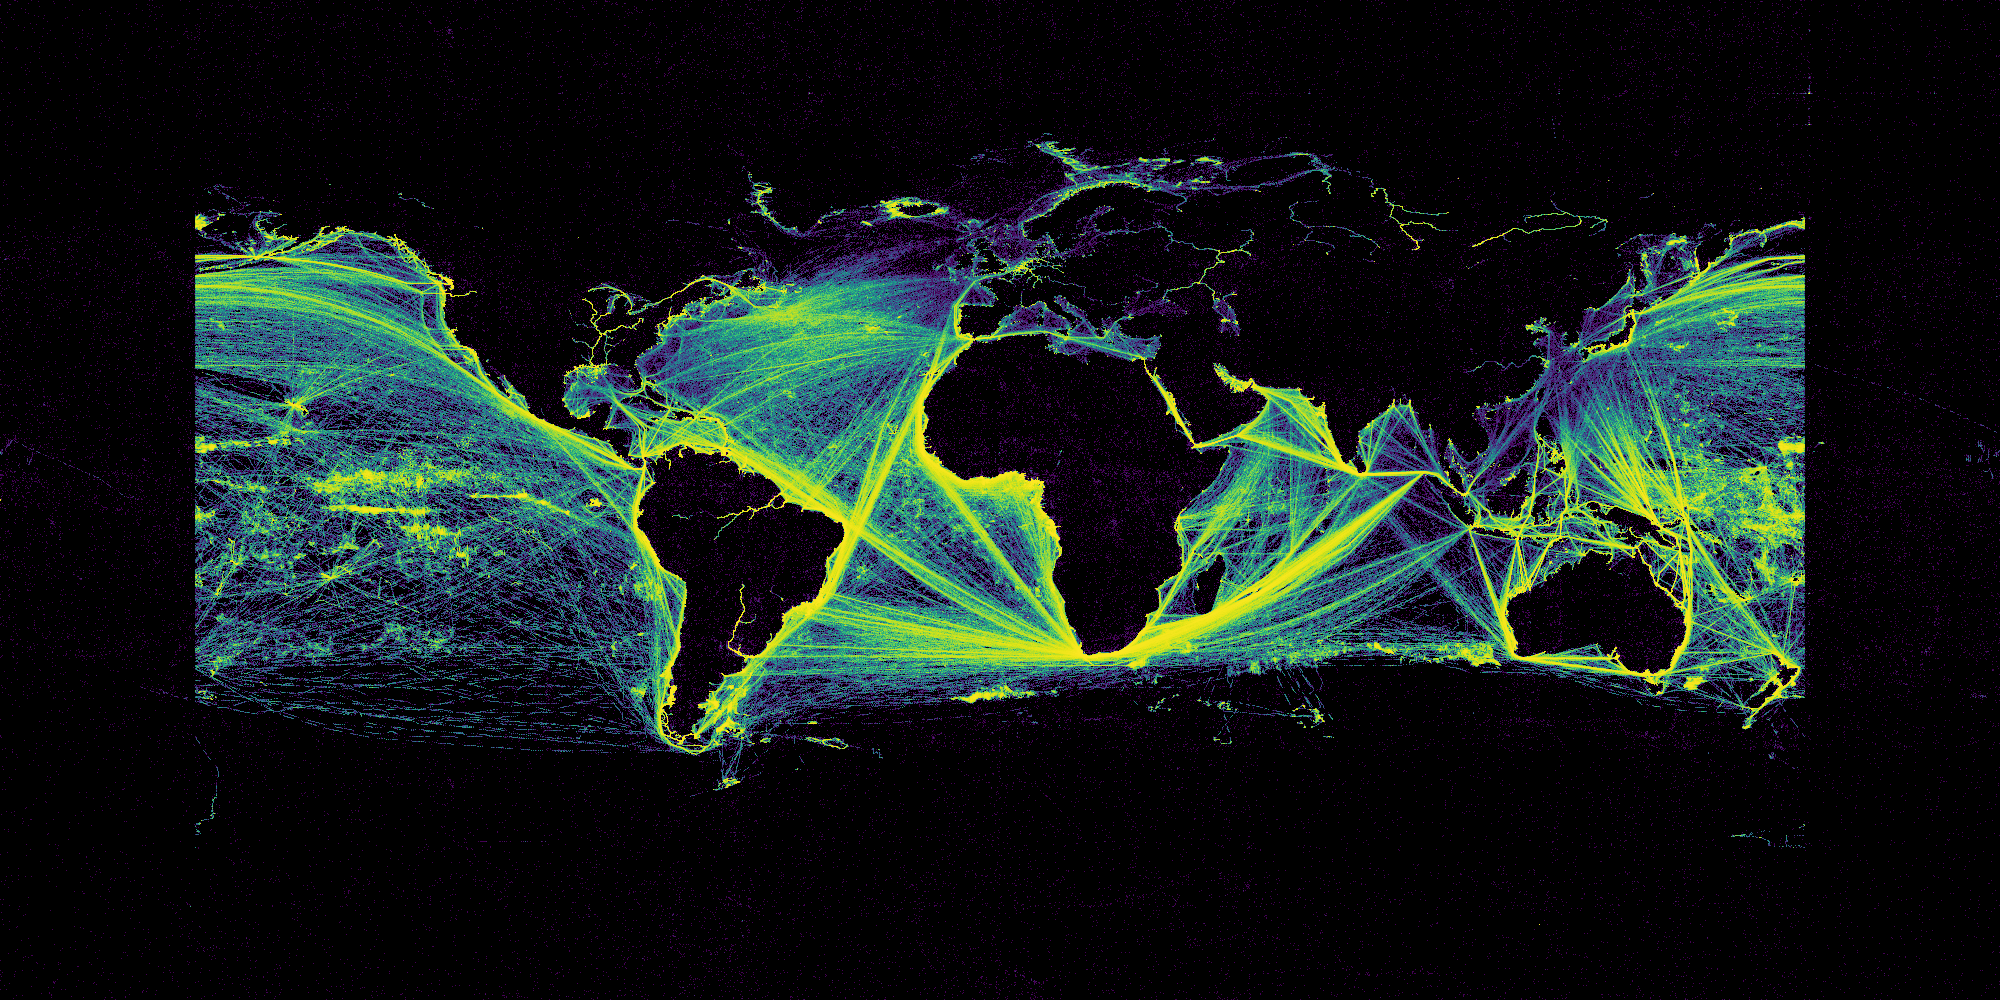

In [7]:
background = "black"
export = partial(export_image, background = "black")
cm = partial(colormap_select, reverse=(background!="black"))

cvs = ds.Canvas(plot_width=2000, plot_height=1000)
agg = cvs.points(ais_position_all, 'longitude', 'latitude')
export(tf.interpolate(agg, cmap = cm(viridis), how='eq_hist'),"vessels")

### AIS fishing vessels

In [8]:
sql_statement = """
SELECT timestamp, mmsi, ship_and_cargo_type
FROM ais_messages.ais_static;
"""
ais_static_all = ais_query.connect(sql_statement)
ais_static_all.columns = ['timestamp','mmsi','ship_and_cargo_type']

In [9]:
fishing_mmsi = ais_static_all[ais_static_all.ship_and_cargo_type == 30].mmsi.unique()

In [10]:
fishing_positional = ais_position_all[ais_position_all.mmsi.isin(fishing_mmsi)]

/home/wgrimes/.conda/envs/ais_data/lib/python3.5/site-packages/datashader/transfer_functions.py:162: DeprecationWarning: `interpolate` is deprecated; use `shade` instead
  warnings.warn(w)


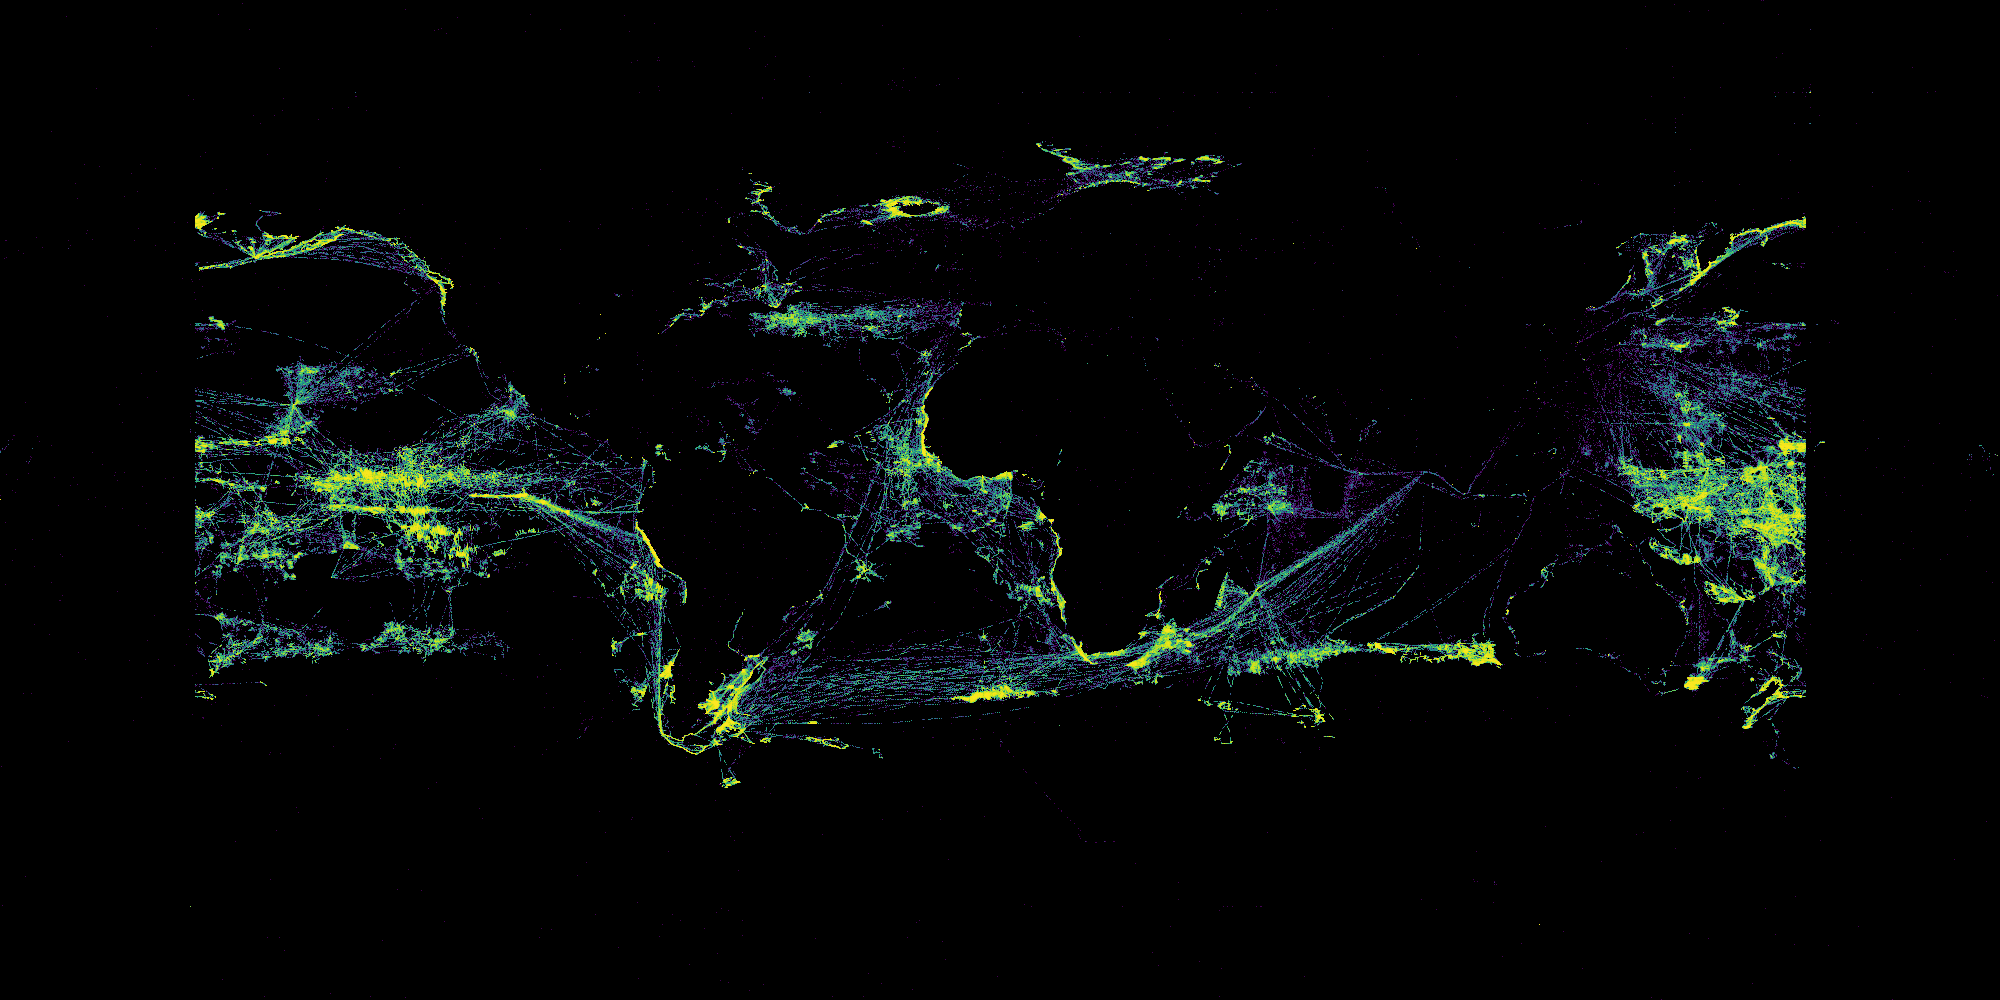

In [11]:
background = "black"
export = partial(export_image, background = background)
cm = partial(colormap_select, reverse=(background!="black"))

cvs = ds.Canvas(plot_width=2000, plot_height=1000)
agg = cvs.points(fishing_positional, 'longitude', 'latitude')
export(tf.interpolate(agg, cmap = cm(viridis), how='eq_hist'),"vessels")

# Map Torres Strait AIS Position

## AIS all vessels

In [16]:
sql_statement = """
SELECT mmsi, longitude, latitude
FROM ais_messages.ais_position
WHERE ((longitude BETWEEN 139 AND 145)
AND (latitude BETWEEN -12 AND -9));
"""
ais_position_torres = ais_query.connect(sql_statement)
ais_position_torres.columns = ['mmsi', 'longitude', 'latitude']

In [21]:
basemap = folium.Map(location=(-10, 142), tiles='openstreetmap', zoom_start=7)
heatmap = plugins.HeatMap(
    zip(ais_position_torres['latitude'], ais_position_torres['longitude']),
    gradient={0.3: 'yellow', 0.8: 'orange', 1: 'red'},
    min_opacity=0.6,
    radius=10
)
heatmap = basemap.add_children(heatmap)
heatmap

## AIS fishing vessels

In [25]:
sql_statement = """
SELECT *
FROM ais_messages.ais_static;
"""
ais_static = ais_query.connect(sql_statement)
ais_static.columns = cols_static

In [26]:
ais_position_torres_mmsi_unique = ais_position_torres['mmsi'].unique()

In [27]:
ais_static_torres = ais_static[ais_static['mmsi'].isin(ais_position_torres_mmsi_unique)]

In [28]:
fishing_torres_mmsi = ais_static_torres[ais_static_torres.ship_and_cargo_type == 30].mmsi.unique()

In [29]:
fishing_position_torres = ais_position_all[ais_position_all['mmsi'].isin(fishing_torres_mmsi)]

In [30]:
basemap = folium.Map(location=(-10, 142), tiles='openstreetmap', zoom_start=7)
heatmap = plugins.HeatMap(
    zip(fishing_position_torres['latitude'], fishing_position_torres['longitude']),
    gradient={0.3: 'yellow', 0.8: 'orange', 1: 'red'},
    min_opacity=0.6,
    radius=10
)
heatmap = basemap.add_children(heatmap)
heatmap

## Time Frequency AIS pings

In [33]:
ais_position_all['timestamp'] = ais_position_all['timestamp'].apply(str)
ais_position_all['timestamp'] = ais_position_all['timestamp'].apply(lambda x: datetime.strptime(x,"%Y-%m-%d %H:%M:%S"))

In [35]:
ais_static_all['timestamp'] = ais_static_all['timestamp'].apply(str)
ais_static_all['timestamp'] = ais_static_all['timestamp'].apply(lambda x: datetime.strptime(x,"%Y-%m-%d %H:%M:%S"))

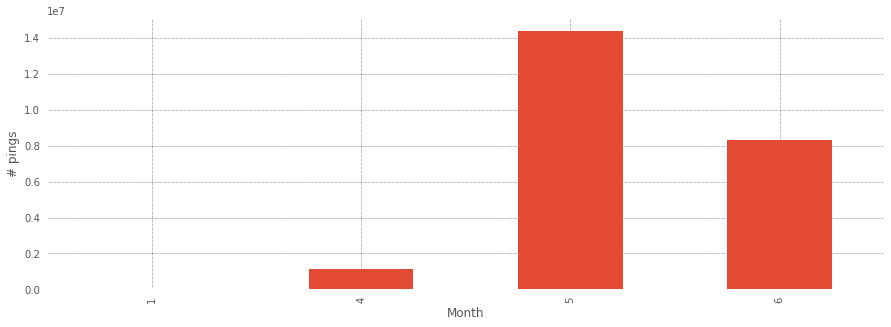

In [68]:
ais_position_all.groupby(ais_position_all.timestamp.dt.month)['timestamp'].count().plot(kind="bar")
plt.xlabel('Month')
plt.ylabel('# pings')

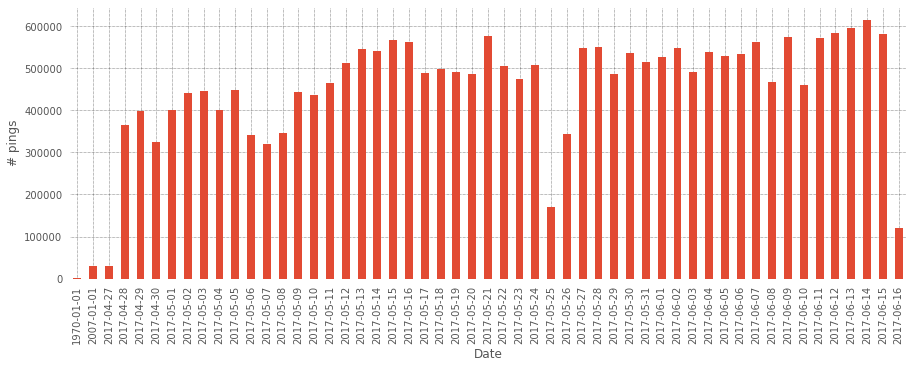

In [69]:
ais_position_all.groupby(ais_position_all.timestamp.dt.date)['timestamp'].count().plot(kind="bar")
plt.xlabel('Date')
plt.ylabel('# pings')

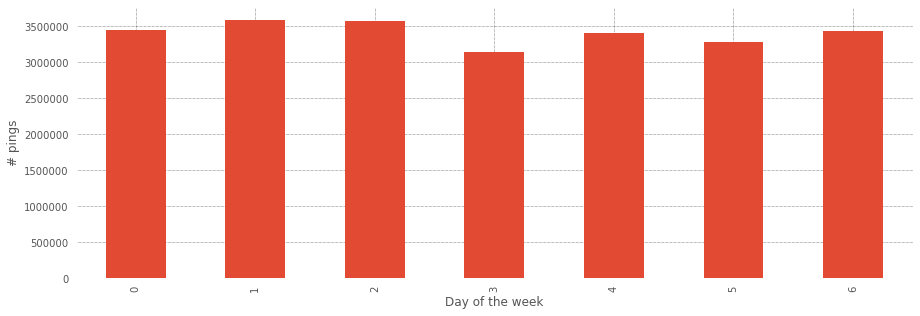

In [70]:
ais_position_all.groupby(ais_position_all.timestamp.dt.weekday)['timestamp'].count().plot(kind="bar")
plt.xlabel('Day of the week')
plt.ylabel('# pings')

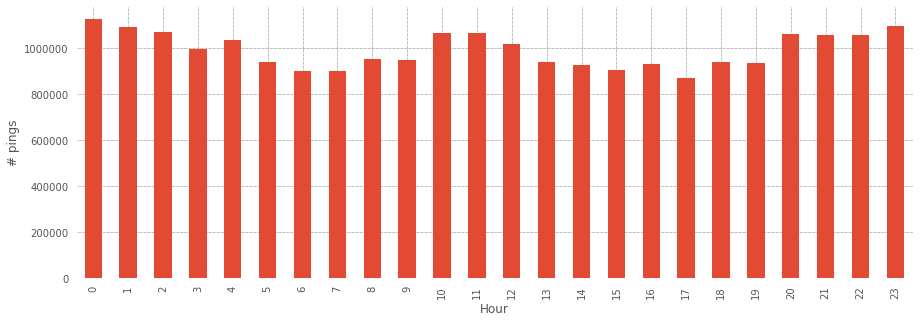

In [71]:
ais_position_all.groupby(ais_position_all.timestamp.dt.hour)['timestamp'].count().plot(kind="bar")
plt.xlabel('Hour')
plt.ylabel('# pings')

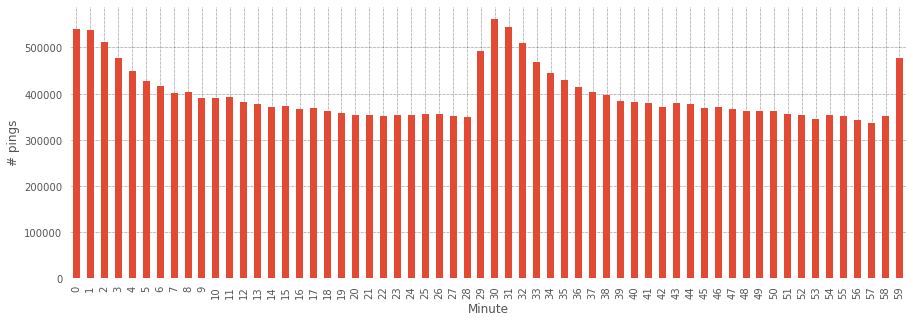

In [72]:
ais_position_all.groupby(ais_position_all.timestamp.dt.minute)['timestamp'].count().plot(kind="bar")
plt.xlabel('Minute')
plt.ylabel('# pings')

Populating the interactive namespace from numpy and matplotlib
